In [1]:
! pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [09:18<00:00, 121MB/s]
100% 11.0G/11.0G [09:18<00:00, 21.2MB/s]


In [5]:
!unzip /content/ucf-crime-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [6]:
train_path = '/content/Train'
test_path = '/content/Test'

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_datagen = image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = 'training',
    shuffle = True,
    seed = 69,
    label_mode = 'categorical',
    image_size = (64,64),
    batch_size = 64)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [8]:
test_datagen = image_dataset_from_directory(
    test_path,
    seed = 69,
    shuffle = False,
    label_mode = 'categorical',
    class_names = None, #
    image_size = (64,64),
    batch_size = 64)

Found 111308 files belonging to 14 classes.


In [9]:
val_datagen = image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = 'validation',
    shuffle = True,
    seed = 69,
    label_mode = 'categorical',
    image_size = (64,64),
    batch_size = 64)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
resnet_model = Sequential()

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout

pre_trained_model = ResNet50(include_top = False, input_shape = (64,64,3), pooling = 'max', classes = 14, weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

resnet_model.add(pre_trained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))#, kernel_regularizer = l2(0.1)))
resnet_model.add(Dense(14, activation = 'softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 24643982 (94.01 MB)
Trainable params: 1056270 (4.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [12]:
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer = Adam(learning_rate = 0.00003), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
resnet_model.fit(train_datagen, validation_data = val_datagen, epochs = 7)

Epoch 1/7
15830/15830 [==============================] - 1610s 101ms/step - loss: 0.1376 - accuracy: 0.9667 - val_loss: 0.0290 - val_accuracy: 0.9937
Epoch 2/7
15830/15830 [==============================] - 1479s 93ms/step - loss: 0.0178 - accuracy: 0.9961 - val_loss: 0.0152 - val_accuracy: 0.9965
Epoch 3/7
15830/15830 [==============================] - 1476s 93ms/step - loss: 0.0088 - accuracy: 0.9982 - val_loss: 0.0113 - val_accuracy: 0.9973
Epoch 4/7
15830/15830 [==============================] - 1474s 93ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0103 - val_accuracy: 0.9975
Epoch 5/7
15830/15830 [==============================] - 1491s 94ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0095 - val_accuracy: 0.9977
Epoch 6/7
15830/15830 [==============================] - 1500s 95ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0088 - val_accuracy: 0.9979
Epoch 7/7
15830/15830 [==============================] - 1539s 97ms/step - loss: 0.0033 - accuracy: 0.999

In [ ]:
resnet_model.save('UCF.h5')

In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np

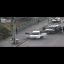

In [15]:
img = image.load_img('/content/Test/Arrest/Arrest024_x264_1270.png', target_size = (64,64))
img

In [16]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0) #expanding the dimension of the array
pred = np.argmax(resnet_model.predict(x)) #predict the higher probability index
op =['abuse', 'arrest', 'arson', 'assult', 'burglary', 'explosion', 'fighting', 'normal', 'road accident', 'robbery', 'shooting', 'shoplifting', 'stealing', 'vandalism']
op[pred]

1/1 [==============================] - 3s 3s/step


'arrest'